In [4]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
import json
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
from torchvision import transforms
import torchvision.transforms.functional as TF
import cv2
import torch.nn as nn
from torchvision.models.segmentation import lraspp_mobilenet_v3_large, LRASPP_MobileNet_V3_Large_Weights

# Define the model repository; here we use the popular Stable Diffusion v1.4
model_id = "CompVis/stable-diffusion-v1-4"

# Load the DDPM scheduler from the model repository
# Note: The 'subfolder="scheduler"' assumes that the model repo contains a scheduler config.
scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")

# Create the Stable Diffusion pipeline with the DDPM scheduler
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    scheduler=scheduler,       # Inject the DDPM scheduler
    revision="fp16",           # Use the fp16 model weights if available for speed
    torch_dtype=torch.float16
)

# Move the pipeline to GPU if available
pipe.to("cuda")

/root/miniconda3/envs/dino_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/dino_env/lib/python3.10/site-packages/diffusers/pipelines/pipeline_loading_utils.py:219: FutureWarning: You are loading the variant fp16 from CompVis/stable-diffusion-v1-4 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
unet/diffusion_pytorch_model.safetensors not found
Loading pipeline components...:  14%|█▍        | 1/7 [00:00<00:01,  4.71it/s]An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/unet: Error no file named diffusi

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.30.3",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [5]:
def show_images_grid(images, rows, cols, figsize=(10, 10)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis("off")  # Hide axes
        else:
            ax.set_visible(False)  # Hide empty subplots

    plt.tight_layout()
    plt.show()

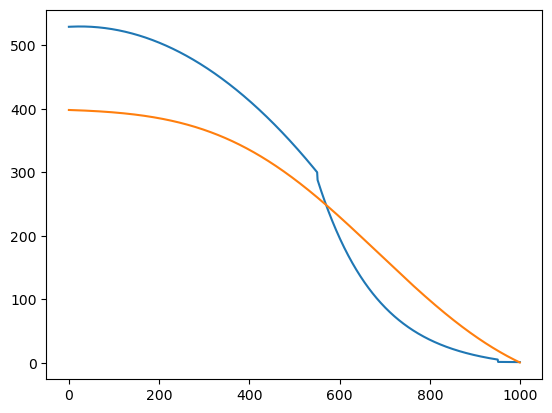

In [6]:
import numpy as np

#exp on different schedule

def custom_mapping(x):
    """
    Maps integers [1, 999] into a function in range [0, 400] with the specified properties:
    - f(1) = 400
    - f(999) = 0
    - Slow decrease from 1 to 700
    - Fast decrease from 700 to 900
    - Almost no change from 900 to 999
    """
    x = np.clip(x, 1, 999)  # Ensure x is within the range
    if x <= 550:
        return (-(x + 500) * (x - 550)/ 1200 + 300)   # Quadratic decay (slow)
    elif x <= 950:
        return 300 * np.exp(-1.5 * (x - 550) / 200) - 10  # Exponential decay (fast)
    else:
        return 300 * np.exp(-4) * (1 - 0.1 * (x - 900) / 99) - 4  # Almost constant


x_values = np.arange(0, 1000)
y_values = np.array([custom_mapping(x) for x in x_values])

plt.plot(y_values)
plt.plot(400 * (1 - pipe.scheduler.alphas_cumprod.cpu().numpy()[::-1]))

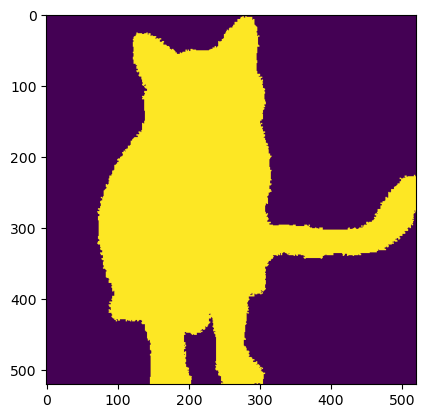

In [7]:
mask = transforms.ToTensor()(cv2.imread("/job/processed_data/cat/cat003_mask.jpg", cv2.IMREAD_GRAYSCALE) > 40)
mask = TF.resize(mask, (520, 520), interpolation=TF.InterpolationMode.BILINEAR)
plt.imshow(mask.permute(1, 2, 0))

In [8]:
criterion = nn.CrossEntropyLoss()
segmentator = lraspp_mobilenet_v3_large(LRASPP_MobileNet_V3_Large_Weights.DEFAULT).to("cuda:1")

/root/miniconda3/envs/dino_env/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [9]:
# index in segmentator results
label_2_idx_map = {"cat": 8, "dog": 12}


In [10]:
cur_class = "cat"

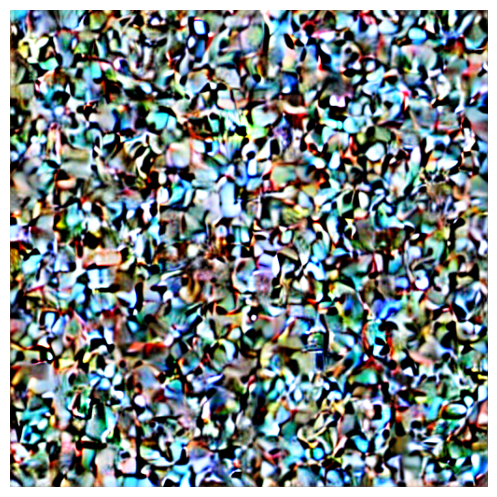

  3%|▎         | 14/500 [00:41<24:03,  2.97s/it]


KeyboardInterrupt: 

In [13]:
import json 
import os

with open(f"/job/processed_data/{cur_class}/annotations.json", "r") as f:
    annotations = json.load(f)

for val, key in annotations.items():
    try:
        mask_path = f"/job/processed_data/{cur_class}/{val}_mask.jpg"
        mask = transforms.ToTensor()(cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) > 40)
        mask = TF.resize(mask, (520, 520), interpolation=TF.InterpolationMode.BILINEAR)
        prop = key
        if not os.path.exists(mask_path):
            print("?")

        device="cuda:0"
        output_type = "pil"
        guidance_scale = 1.5

        height = pipe.unet.config.sample_size * pipe.vae_scale_factor
        width = pipe.unet.config.sample_size * pipe.vae_scale_factor

        num_images = 1

        with torch.no_grad():
            prompt_embeds = pipe._encode_prompt(
                prop,
                device,
                num_images_per_prompt=num_images,
                do_classifier_free_guidance=True,
                negative_prompt=None,
                prompt_embeds=None,
                negative_prompt_embeds=None,
                lora_scale=None,
            )

        # 4. Prepare timesteps
        num_inference_steps = 500
        pipe.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = pipe.scheduler.timesteps

        # 5. Prepare latent variables
        num_channels_latents = pipe.unet.config.in_channels
        latents = pipe.prepare_latents(
            num_images,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator=None,
            latents=None,
        )
        latents.requires_grad_(False)

        trans = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        s_schedule = np.flip(y_values)

        k = 10
        m = 10
        # 7. Denoising loop
        for i, t in tqdm(enumerate(timesteps), total=num_inference_steps):
            for _ in range(k):
                z_t = latents.detach().clone()
                z_t.requires_grad_(True)
                latent_model_input = z_t.repeat(2, 1, 1, 1) # classifier free guidance
                latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                # with torch.no_grad():
                pipe.unet.zero_grad()
                noise_pred = pipe.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    cross_attention_kwargs=None,
                    return_dict=False,
                )[0]

                # classifier free guidance
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                alpha_prod_t = pipe.scheduler.alphas_cumprod[timesteps[i]]
                alpha_prod_t_prev = pipe.scheduler.alphas_cumprod[timesteps[i + 1]] if i + 1 < len(timesteps) else torch.tensor(1.0)


                # todo
                pipe.vae.zero_grad()
                segmentator.zero_grad()

                z_zero = (z_t - (1 - alpha_prod_t) ** 0.5 * noise_pred) / alpha_prod_t ** 0.5

                img = pipe.vae.decode(z_zero / pipe.vae.config.scaling_factor, return_dict=False)[0]
                map = (img + 1) * 0.5
                map = TF.resize(map, (520, 520), interpolation=TF.InterpolationMode.BILINEAR)
                map = trans(map)

                seg_logits = segmentator(map.to("cuda:1").float())['out']

                class8_logits = seg_logits[:, label_2_idx_map[cur_class], :, :]

                loss = torch.nn.functional.binary_cross_entropy_with_logits(class8_logits, mask.to("cuda:1").expand(num_images, 520, 520).float())

                loss.backward()
                noise_pred += 400 * (1 - alpha_prod_t) * z_t.grad

                # compute the previous noisy sample x_t -> x_t-1
                next_latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
                latents = (alpha_prod_t/alpha_prod_t_prev)**0.5 * next_latents \
                    + (1 - alpha_prod_t/alpha_prod_t_prev)**0.5 * torch.randn_like(next_latents)
            latents = next_latents


            # with torch.no_grad():
            #     plt.close()
            #     clear_output()
            #     image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]
            #     images = pipe.image_processor.postprocess(image.detach(), output_type=output_type, do_denormalize=[True] * num_images)
            #     show_images_grid(images, rows=2, cols=2)
            
        with torch.no_grad():
            plt.close()
            clear_output()
            image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]
            images = pipe.image_processor.postprocess(image.detach(), output_type=output_type, do_denormalize=[True] * num_images)

        images[0].save(f"/job/forward_pass/{cur_class}/{val}.jpg")
    
    except Exception as e:
        print(str(e))
        print(val)